In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import copy
import random
from collections import defaultdict

import energyflow
from particle import Particle
import pennylane as qml
from tqdm import tqdm

import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch.nn import Linear, ReLU, Sigmoid, ModuleList, LeakyReLU, Linear, BatchNorm1d
from torch_geometric.nn import GATConv, global_mean_pool, global_max_pool
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.data import Data, Dataset
from torch.utils.data import Dataset
from torch_geometric.utils import to_networkx
from torch.optim import Adam
from torch_geometric.loader import DataLoader
from torch_geometric.utils import subgraph
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve

import wandb

In [2]:
os.chdir('..');
# print(os.getcwd())
from qssl.loss.losses import ContrastiveLoss
from qssl.training.trainer import run_model, train_model
from qssl.data.data_loader import preprocess_fixed_nodes, create_contrastive_graph_pairs
from qssl.data.data_preprocessing_augmentation import drop_nodes, drop_edges, mask_features, graph_augment
from qssl.utils.utils import visualize_graph_pairs, visualize_graph_pairs_01, plot_and_save_loss

In [3]:
n_connections = 6
input_dims = 8
hidden_dims = [64,32,32]
output_dims = 8
n_qubits = 5
q_depth = 1
epochs = 50
lr = 1e-3
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
batch_size = 1000

In [4]:
X = np.load(r'data/qg_graph/x10_sorted_12500.npy')
y = np.load(r'data/qg_graph/y10_sorted_12500.npy')
N=12500

In [5]:
x_data, y_data, edge_tensor, edge_indx_tensor, edge_attr_matrix, graph_help = preprocess_fixed_nodes(X,y, nodes_per_graph=8)

--- Finding All Unique Particles ---

--- Inserting Masses ---


14it [00:00, 447.48it/s]



--- Calculating Momenta and Energies ---

--- Calculating Edge Tensors ---


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:14<00:00, 869.70it/s]


In [6]:
train_index   = int(N*0.8)
val_index    = int(N*0.9)
dataset = []
for i in tqdm(range(N)):
    dataset.append(Data(edge_index=edge_indx_tensor[i,:,:],
                        x=x_data[i,:,:],
                        edge_attr=edge_attr_matrix[i,:],
                        y=y_data[i]))

original_dataset = dataset

100%|██████████████████████████████████████████████████████████████████████████| 12500/12500 [00:01<00:00, 8217.66it/s]


In [7]:
pairs, labels = create_contrastive_graph_pairs(dataset)

In [8]:
run = wandb.init(
    project = "ML4Sci-QuantumContrastiveLearning",
    config = {
        "dataset":"QG12500",
        "model":"QGNN",
        "loss":"contrastive pair loss"
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


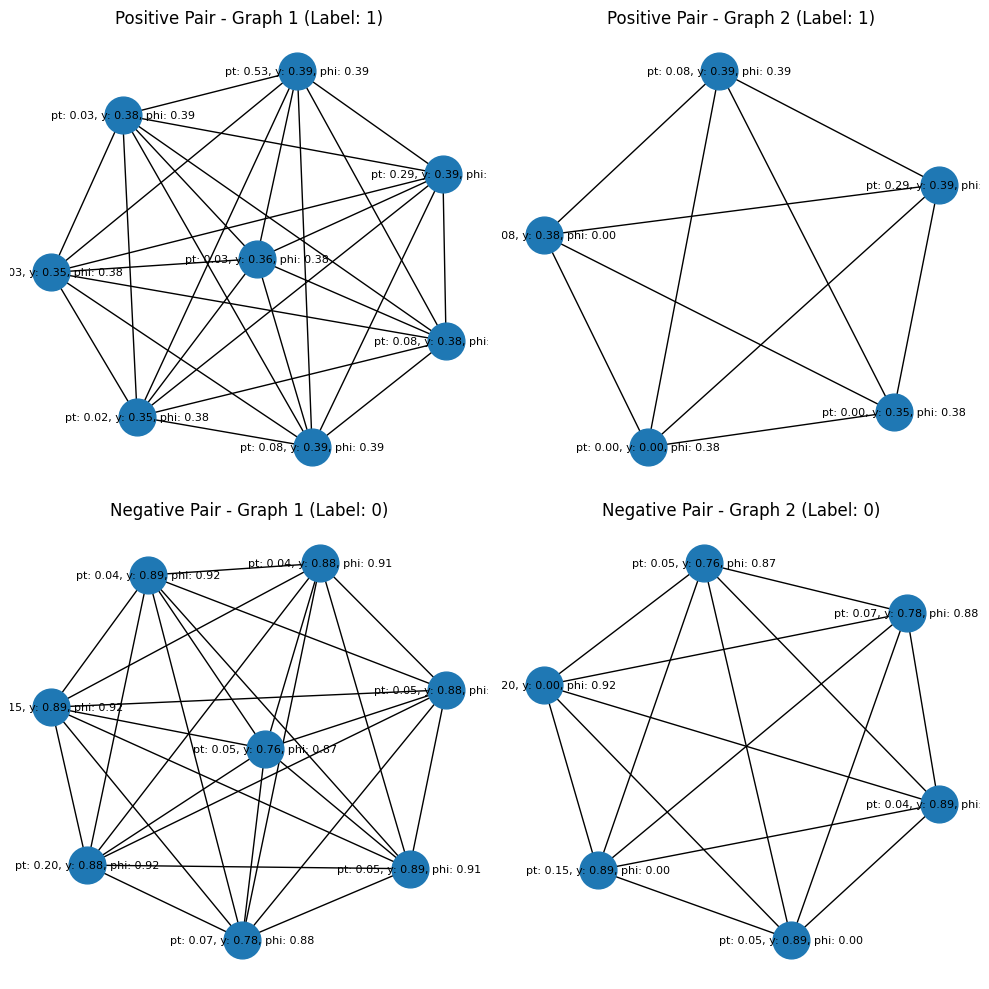

In [9]:
visualize_graph_pairs_01(pairs, labels)

In [10]:
class GraphPairDataset(Dataset):
    def __init__(self, pairs, labels):
        self.pairs = pairs  
        self.labels = labels 
        
    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        graph1, graph2 = self.pairs[idx]
        label = self.labels[idx]
        return graph1, graph2, label

In [11]:
def split_pairs(pairs, labels, train_ratio, val_ratio):
    train_pairs, temp_pairs, train_labels, temp_labels = train_test_split(
        pairs, labels, train_size=train_ratio, random_state=42, stratify=labels
    )
    val_pairs, test_pairs, val_labels, test_labels = train_test_split(
        temp_pairs, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
    )
    
    return train_pairs, train_labels, val_pairs, val_labels, test_pairs, test_labels

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_pairs, train_labels, val_pairs, val_labels, test_pairs, test_labels = split_pairs(
    pairs, labels, train_ratio, val_ratio
)

In [12]:
# Now, create datasets and dataloaders for each split
train_dataset = GraphPairDataset(train_pairs, train_labels)
val_dataset = GraphPairDataset(val_pairs, val_labels)
test_dataset = GraphPairDataset(test_pairs, test_labels)

batch_size = 1000

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [13]:
from qssl.models.qc import quantum_circuit_angle_entangle

In [14]:
# Define the quantum layer using Pennylane
dev = qml.device("default.qubit", wires=n_qubits)

# Define a simple quantum circuit
@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs):
    # Encode classical data into qubits
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)
    
    # Apply a layer of entanglement
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i + 1) % n_qubits])

    # Measure the qubits
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QuantumLayer(torch.nn.Module):
    def __init__(self):
        super(QuantumLayer, self).__init__()

    def forward(self, x):
        q_out = []
        for i in range(x.shape[0]):  # Apply quantum circuit on each input in the batch
            qc_output = quantum_circuit(x[i])
            # Convert the list output to a tensor
            q_out.append(torch.tensor(qc_output, dtype=torch.float32))
        return torch.stack(q_out)




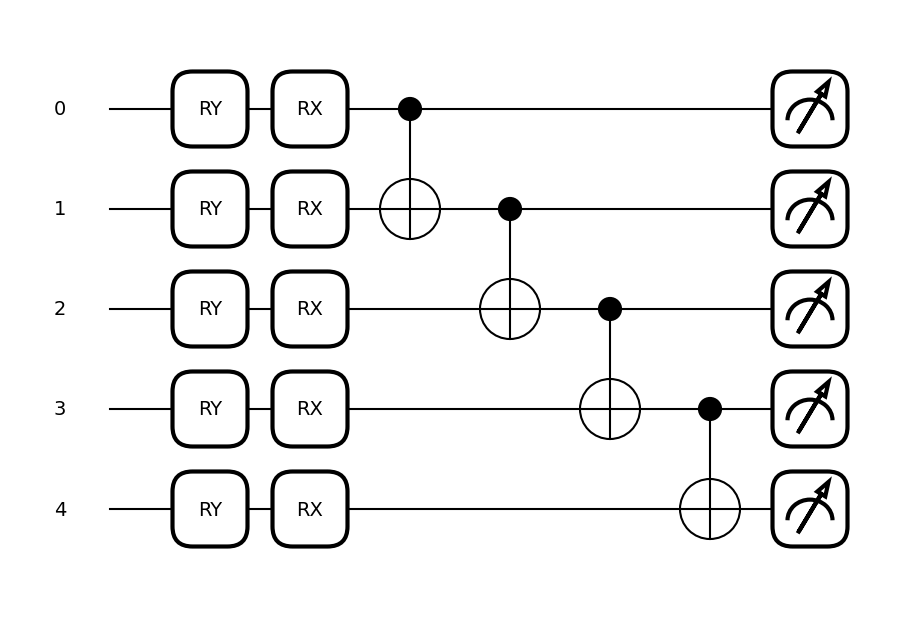

In [15]:
n_qubits=5
example_inputs = torch.rand(n_qubits)
weights = np.random.random((1, n_qubits))
X=[1,2,3,4]
# quantum_circuit_angle_entangle(example_inputs,weights,5)

# Draw the circuit
fig, ax = qml.draw_mpl(quantum_circuit_angle_entangle)(example_inputs,weights,5)
# wandb.log({"QGNN Quantum Circuit": wandb.Image(fig)})
plt.show()

In [16]:
# Hybrid Quantum-Classical GNN model
class HybridQuantumGNN(torch.nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims, activ_fn):
        super().__init__()
        layers = []
        self.norm_layers = []
        self.residual_projections = []  # To project residuals if needed
        
        # Initial GAT Layer
        layers.append(GATConv(input_dims, hidden_dims[0]))
        self.norm_layers.append(BatchNorm1d(hidden_dims[0]))
        if input_dims != hidden_dims[0]:
            self.residual_projections.append(Linear(input_dims, hidden_dims[0]))
        else:
            self.residual_projections.append(None)
        
        # Additional Graph Layers with Residuals and Normalization
        for i in range(len(hidden_dims) - 1):
            layers.append(GATConv(hidden_dims[i], hidden_dims[i+1]))
            self.norm_layers.append(BatchNorm1d(hidden_dims[i+1]))
            if hidden_dims[i] != hidden_dims[i+1]:
                self.residual_projections.append(Linear(hidden_dims[i], hidden_dims[i+1]))
            else:
                self.residual_projections.append(None)
        
        self.layers = ModuleList(layers)
        self.norm_layers = ModuleList(self.norm_layers)
        self.residual_projections = ModuleList(self.residual_projections)
        self.activ_fn = activ_fn
        
        # Quantum Layer
        self.quantum_layer = QuantumLayer()

        # Classical Readout Layer
        self.readout_layer = Linear(hidden_dims[-1] * 2 + n_qubits, output_dims)  # Combining GNN and quantum outputs
        self.dropout = torch.nn.Dropout(p=0.5)  

    def forward(self, x, edge_index, batch):
        h = x
        for i in range(len(self.layers)):
            residual = h  # Residual connection
            h = self.layers[i](h, edge_index)
            h = self.norm_layers[i](h)
            h = self.activ_fn(h)
            h = self.dropout(h)
            
            # Project residual if needed
            if self.residual_projections[i] is not None:
                residual = self.residual_projections[i](residual)
            
            h = h + residual  # Adding residual connection
        
        # Multi-head readout: mean pooling + max pooling
        h_mean = global_mean_pool(h, batch)
        h_max = global_max_pool(h, batch)
        h_gnn = torch.cat([h_mean, h_max], dim=1)

        # Quantum layer output
        h_quantum = self.quantum_layer(h_gnn)

        # Combine GNN and quantum layer outputs
        h_combined = torch.cat([h_gnn, h_quantum], dim=1)

        # Final readout layer for graph-level embedding
        return self.readout_layer(h_combined)


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the custom contrastive loss using quantum fidelity
class QuantumFidelityContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(QuantumFidelityContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Compute the fidelity between the two quantum states
        # Fidelity = |<psi|phi>|^2 = |dot(output1, output2)|^2
        fidelity = torch.abs(torch.sum(output1 * output2, dim=-1)) ** 2
        
        # Contrastive loss
        loss_similar = (1 - fidelity) ** 2  # For similar pairs
        loss_dissimilar = F.relu(fidelity - self.margin) ** 2  # For dissimilar pairs
        
        # Combine the loss using the labels (1 for similar, 0 for dissimilar)
        loss = label * loss_similar + (1 - label) * loss_dissimilar
        return torch.mean(loss)

# # Example usage within the training loop
# lossFn = QuantumFidelityContrastiveLoss(margin=1.0)

# # Forward pass in your training loop
# # Get quantum embeddings from the model (emb1 and emb2 are graph pair embeddings)
# output1 = model(data1.x.float(), data1.edge_index, data1.batch)
# output2 = model(data2.x.float(), data2.edge_index, data2.batch)

# # Compute quantum fidelity-based contrastive loss
# label = torch.tensor([1 if data1.label == data2.label else 0])  # Label: 1 for similar, 0 for dissimilar
# loss = lossFn(output1, output2, label)


In [18]:
from qssl.training.trainer import run_qmodel, train_qmodel

In [19]:
model = HybridQuantumGNN(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lossFn = QuantumFidelityContrastiveLoss(margin=1.0)  # Use contrastive loss in pair mode
history = train_qmodel(model, optimizer, lossFn=lossFn, epochs=50, lr=0.001, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

Epoch 1, Train Loss: 15987.9695, Val Loss: 0.0685
Epoch 2, Train Loss: 971.1713, Val Loss: 0.1995
Epoch 3, Train Loss: 312.1261, Val Loss: 0.7988
Epoch 4, Train Loss: 329.3489, Val Loss: 2.5589
Epoch 5, Train Loss: 129.7093, Val Loss: 2.8588
Epoch 6, Train Loss: 72.4665, Val Loss: 2.4468
Epoch 7, Train Loss: 64.8893, Val Loss: 2.0682
Epoch 8, Train Loss: 52.0410, Val Loss: 1.8031
Epoch 9, Train Loss: 32.8414, Val Loss: 1.5543
Epoch 10, Train Loss: 80.2470, Val Loss: 1.4358
Epoch 11, Train Loss: 32.2964, Val Loss: 1.2068
Epoch 12, Train Loss: 27.9839, Val Loss: 1.1467
Epoch 13, Train Loss: 28.2786, Val Loss: 1.1234
Epoch 14, Train Loss: 33.5965, Val Loss: 1.0526
Epoch 15, Train Loss: 42.3948, Val Loss: 1.0531
Epoch 16, Train Loss: 23.3413, Val Loss: 0.9759
Epoch 17, Train Loss: 26.7066, Val Loss: 0.9578
Epoch 18, Train Loss: 25.4093, Val Loss: 0.8757
Epoch 19, Train Loss: 19.8394, Val Loss: 0.8083
Epoch 20, Train Loss: 21.0978, Val Loss: 0.8003
Epoch 21, Train Loss: 16.6679, Val Loss: 0

### LCT: Linear Classification Test

In [22]:
def run_model_lct(model, epoch, dataloader, lossFn, optimizer=None, train=True, return_embeddings=False):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0
    correct = 0
    num_samples = 0
    all_embeddings = []
    all_labels = []

    for batch in dataloader:
        optimizer.zero_grad() if train else None

        # Extract the pairs and labels from the dataloader batch
        data1, data2, labels = batch[0], batch[1], batch[2]
        
        # Get the embeddings for both graphs
        emb1 = model(data1.x.float(), data1.edge_index, data1.batch)
        emb2 = model(data2.x.float(), data2.edge_index, data2.batch)
        
        if return_embeddings:
            # Save embeddings and labels for later use in classification
            all_embeddings.append(emb1.detach().cpu())
            all_labels.append(labels.detach().cpu())

        # Compute contrastive loss
        loss = lossFn(emb1, emb2, labels)
        
        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * data1.num_graphs
        num_samples += data1.num_graphs

        # Compute accuracy
        with torch.no_grad():
            cos_sim = torch.nn.functional.cosine_similarity(emb1, emb2)
            predictions = (cos_sim > 0.5).long()  # You can adjust the threshold
            correct += (predictions == labels).sum().item()

    avg_loss = total_loss / num_samples
    accuracy = correct / num_samples

    if return_embeddings:
        return torch.cat(all_embeddings, dim=0), torch.cat(all_labels, dim=0)
    return avg_loss, accuracy


In [23]:
# After training, use the run_model function to extract embeddings from the validation/test dataset
train_embeddings, train_labels = run_model_lct(model, epoch=0, dataloader=train_dataloader, lossFn=lossFn, return_embeddings=True, train=False)
test_embeddings, test_labels = run_model_lct(model, epoch=0, dataloader=test_dataloader, lossFn=lossFn, return_embeddings=True, train=False)

# Convert embeddings and labels to numpy arrays for scikit-learn
X_train = train_embeddings.cpu().numpy()
y_train = train_labels.cpu().numpy()
X_test = test_embeddings.cpu().numpy()
y_test = test_labels.cpu().numpy()

Linear Classifier Test Accuracy: 57.01%
QGNN AUC Score: 0.5929


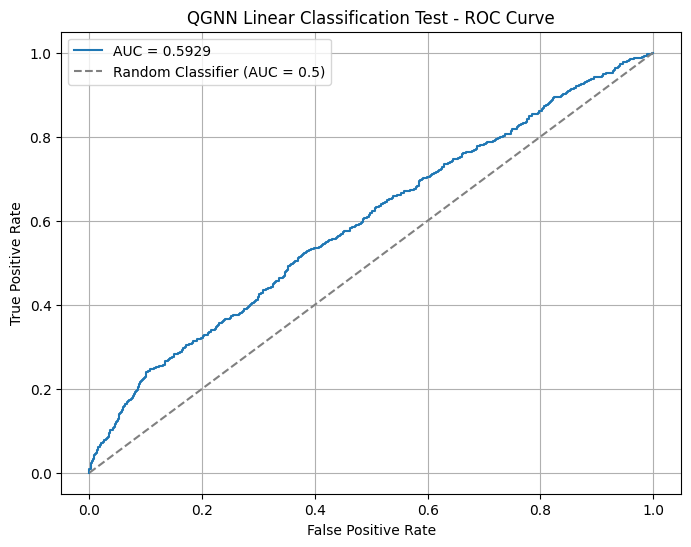

Confusion Matrix:
[[577 365]
 [441 492]]


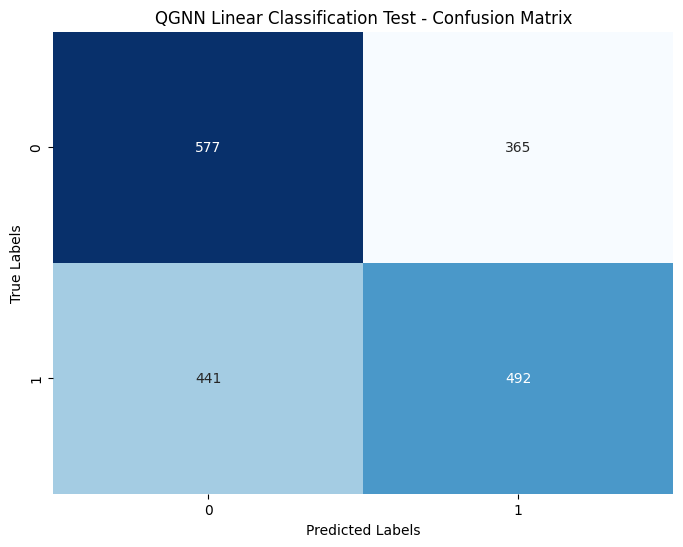

In [24]:
## Linear Classification Test
# Train a simple linear classifier (Logistic Regression)
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# Predict on test set
y_pred = classifier.predict(X_test)

# Compute accuracy of the linear classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Linear Classifier Test Accuracy: {accuracy * 100:.2f}%")
wandb.log({"QGNN Linear Classifier Test Accuracy": f"{accuracy * 100:.2f}%"})

# Compute the AUC score and plot the ROC curve
if len(np.unique(y_test)) == 2:  # Binary classification
    y_prob = classifier.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
    auc_score = roc_auc_score(y_test, y_prob)
    print(f"QGNN AUC Score: {auc_score:.4f}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    
    # Add the diagonal line representing random guessing
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier (AUC = 0.5)")
    
    # Label the plot
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("QGNN Linear Classification Test - ROC Curve")
    plt.legend()
    plt.grid(True)
    
    # Save and log the plot to WandB
    plt.savefig("roc_curve.png")
    wandb.log({"QGNN ROC Curve": wandb.Image("roc_curve.png")})
    
    # Show the plot (optional)
    plt.show()

# Compute and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('QGNN Linear Classification Test - Confusion Matrix')

# Save and log the confusion matrix plot to WandB
plt.savefig("confusion_matrix.png")
wandb.log({"QGNN Confusion Matrix": wandb.Image("confusion_matrix.png")})

plt.show()

In [25]:
wandb.finish()

qgnn epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
qgnn train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
qgnn val_loss,▁▁▃██▇▆▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂
QGNN Linear Classifier Test Accuracy,57.01%
qgnn epoch,50
qgnn train_loss,11.37401
qgnn val_loss,0.51341
